## Causal Diagrams

Causal diagrams are a powerful tool to represent and reason about causal relationships between variables. In this notebook, we will explore how to create and analyze causal diagrams using Python.

<a target="_blank" href="https://colab.research.google.com/github/CausalAILab/causalai-book/blob/main/causal_diagram.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
import os
import sys

if 'google.colab' in sys.modules:
    os.system("git clone https://github.com/CausalAILab/causalai-book.git")
    os.system("mv causalai-book/* ./")
    os.system("rm -rf causalai-book")

In [2]:
# Install libraries
# !pip install toposort
# !pip install pydash

In this notebook, we will see how to use the Causal Graph and perform some cool functions with it.

In [4]:
# Importing the necessary libraries and modules for causal inference
from src.fusion import *

ModuleNotFoundError: No module named 'toposort'

In [5]:
# Define the nodes for the causal diagram.
# Each node has a name, label, and type.
# 'basic' type refers to observable variables, while 'latent' would refer to unobserved variables.
# The label is optional and is used for display purposes.
# The name is used to refer to the variable in the causal graph.
# The order of the nodes in the list does not matter.

nodes = [
    {
        'name': 'Z', # Can be any string
        'label': 'Z', # Can be any string (optional)
        'type': 'basic' # Can be 'basic' or 'latent'
    },
    {
        'name': 'X',
        'label': 'X',
        'type': 'basic'
    },
    {
        'name': 'Y',
        'label': 'Y',
        'type': 'basic'
    }
]

In [6]:
# Define the edges between the nodes. 
# Each edge represents a causal relationship from one node to another.
# The 'type' can be 'directed', 'bidirected', or 'undirected', specifying the nature of the relationship.
# The 'label' is optional and is used for display purposes.
# The 'from_' and 'to_' keys are used to specify the source and target nodes of the edge.
# The order of the edges in the list does not matter.

edges = [
    {
        'from_': 'Z', # one of the node names
        'to_': 'X', # one of the node names
        # 'label': '', # any string (optional)
        'type': 'directed' # Can be 'directed', 'bidirected' or 'undirected'
    },
    {
        'from_': 'Z',
        'to_': 'Y',
        # 'label': '', # any string (optional)
        'type': 'directed' # Can be 'directed', 'bidirected' or 'undirected'
    },
    {
        'from_': 'X',
        'to_': 'Y',
        # 'label': '',
        'type': 'directed' # Can be 'directed', 'bidirected' or 'undirected'
    }
]

In [7]:
# Import the Graph class from the graph module
from src.graph.classes.graph import Graph

ModuleNotFoundError: No module named 'toposort'

In [7]:
# Instantiate a graph object using the previously defined nodes and edges.
# This will represent our causal graph.
G = Graph(nodes=nodes, edges=edges)

The causal graph is now set up with the defined nodes and edges. Next, we'll analyze it to identify causal paths and potential backdoor adjustment sets. As we progress through the course, we’ll dive into more advanced techniques and exciting applications.

### D-Separation

Now, we will try to find paths between two sets of nodes, that are blocked by a third set of variables.

First we need the nodes.

In [8]:
from src.inference.utils.graph_utils import GraphUtils as gu

In [9]:
X = gu.getNodesByName(['X'], G)
X

[{'name': 'X', 'label': 'X', 'type_': 'basic', 'metadata': {}}]

In [10]:
Y = gu.getNodesByName(['Y'], G)
Z = gu.getNodesByName(['Z'], G)

Now, let's get the paths between $X$ and $Y$ that are blocked by $Z$ and not blocked by $Z$.

In [11]:
from src.path_analysis.d_separation import DSeparation

In [12]:
connectedPaths = DSeparation.findDConnectedPaths(G, X, Y, Z)
separatedPaths = DSeparation.findDSeparatedPaths(G, X, Y, Z)

An alternate way to get here.

In [13]:
fileContent = '''
<NODES>
Z
X
Y

<EDGES>
Z -> X
Z -> Y
X -> Y

<TASK>
treatment: X
outcome: Y
adjusted: Z
'''

In [14]:
result = listDSeparationPaths(fileContent)

In [15]:
result

{'G': <src.graph.classes.graph.Graph at 0x1089fa910>,
 'connectedPaths': [<src.path_analysis.classes.path.Path at 0x1089fa9d0>],
 'separatedPaths': [<src.path_analysis.classes.path.Path at 0x1089faac0>]}

In [16]:
print(connectedPaths[0].edges[0].edge)
print(result['connectedPaths'][0].edges[0].edge)

{'from_': 'X', 'to_': 'Y', 'label': None, 'type_': 'directed', 'metadata': {}}
{'from_': 'X', 'to_': 'Y', 'label': None, 'type_': 'directed', 'metadata': {}}


How to visualize?

In [17]:
from src.utils import plot_causal_diagram

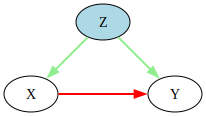

In [18]:
graph = plot_causal_diagram(result['G'], 
                            result['connectedPaths'],
                            result['separatedPaths'],
                            nodes=['Z'],
                            node_positions = {'Z': (0, 0), 'X': (-1, -1), 'Y': (1, -1)})
graph

You want to learn more? Let's compute $P(Y \mid do(x))$. Before that, let's find the backdoor admissible sets.

In [19]:
from src.inference.classes.causal_query import CausalQuery
from src.inference.engines.backdoor_engine import BackdoorEngine

In [20]:
from src.adjustment.backdoor_adjustment import BackdoorAdjustment as BD

In [21]:
# Get the list of admissible sets for the causal query
bd_sets = BD.listAdmissibleSets(G, X, Y)

In [22]:
bd_sets

[['Z']]

Now, let's compute $P(Y \mid do(x))$.

We are now ready to calculate the causal effect of $X$ on $Y$ using the backdoor criterion. The backdoor adjustment formula will be applied here.

In [23]:
# Initiate the engine for causal inference
engine = BackdoorEngine()

In [24]:
# Define the query for causal inference
query = CausalQuery(X, Y)

In [25]:
result = engine.compute(query, G)

In [26]:
from src.inference.utils.expression_utils import ExpressionUtils as eu

In [27]:
# Format the result into a readable causal expression.
# This expression provides the formula for calculating the causal effect using the backdoor adjustment.
exp = eu.write(result)
print(exp)

\sum_{Z}{P\left(Y \middle| X,Z\right)P\left(Z\right)}


In [28]:
from IPython.display import display, Latex

In [29]:
display(Latex(f'${exp}$'))

<IPython.core.display.Latex object>

Find $P(Y \mid do(x))$ using do-calculus.

In [30]:
from src.inference.engines.do_calculus_engine import DoCalculusEngine

In [31]:
engine_do = DoCalculusEngine()

In [32]:
result = engine_do.compute(query, G)

In [33]:
exp_do = eu.write(result)
print(exp_do)

\sum_{Z}{P\left(Y \middle| X,Z\right)P\left(Z\right)}


In [34]:
display(Latex(f'${exp_do}$'))

<IPython.core.display.Latex object>

Test do-calculus Rules

In [36]:
from src.graph_analysis.classes.probability_expression import ProbabilityExpression
from src.graph_analysis.do_calculus.do_calculus_inspector import DoCalculusInspector
from src.graph_analysis.do_calculus.classes.do_calculus_inspection_query import DoCalculusInspectionQuery

In [37]:
X = gu.getNodesByName(['X'], G)
Y = gu.getNodesByName(['Y'], G)
Z = gu.getNodesByName(['Z'], G)
P = ProbabilityExpression(X = X, Y = Y, Z = Z)

In [38]:
do_calculus_rule = 1

In [39]:
query = DoCalculusInspectionQuery()
query.rule = do_calculus_rule
query.P = P

In [40]:
inspector = DoCalculusInspector()
result = inspector.test(query, G)

In [41]:
inspector.printResult(query, result)

Applicable: False
Expression: P\left(Y \middle| do(X), Z\right)
Evaluation: \left(Y \perp Z | X\right)_{G_{\overline{X}}}
Result: P\left(Y \middle| do(X), Z\right) \neq P\left(Y \middle| do(X)\right)


In [45]:
from src.utils import display_inspector_result

In [46]:
display_inspector_result(result, latex=True)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>